# LAB 4 - COMPARING REGRESSION MODELS

In [290]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

%matplotlib inline

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

In [291]:
customer_df = pd.read_csv('we_fn_use_c_marketing_customer_value_analysis.csv')

### First of all, I will clean the dataset according to the criteria defined in the previous labs.

In [292]:
# First of all, we will remove duplicated rows, in case there are any. 
customer_df = customer_df.drop_duplicates()

In [293]:
# Standardizing header names
cols = []
for i in range(len(customer_df.columns)):
    cols.append(customer_df.columns[i].lower().replace(' ', '_'))
customer_df.columns = cols

In [294]:
# Converting effective_to_date into datetime
customer_df['effective_to_date'] = pd.to_datetime(customer_df['effective_to_date'], errors='coerce')

In [295]:
# Function to split continuous and discrete variables. Done in lab1 but it is in a different Jupyter Notebook.

def cont_disc(DataFrame):
    continuous = []
    discrete = []

    threshold = customer_df.shape[0] * 0.03 

    for x in customer_df.columns:    # df.index for rows
        if customer_df[x].nunique() < threshold:
            discrete.append(x)
        else:
            continuous.append(x)
    return discrete, continuous

discrete, continuous = cont_disc(customer_df)

In [296]:
discrete_df = customer_df[discrete]
continuous_df = customer_df[continuous]
display(discrete_df.head())
display(continuous_df.head())

,state,response,coverage,education,effective_to_date,employmentstatus,gender,location_code,marital_status,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
0,Washington,No,Basic,Bachelor,2011-02-24,Employed,F,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize
1,Arizona,No,Extended,Bachelor,2011-01-31,Unemployed,F,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize
2,Nevada,No,Premium,Bachelor,2011-02-19,Employed,F,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize
3,California,No,Basic,Bachelor,2011-01-20,Unemployed,M,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize
4,Washington,No,Basic,Bachelor,2011-02-03,Employed,M,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize


,customer,customer_lifetime_value,income,total_claim_amount
0,BU79786,2763.52,56274,384.81
1,QZ44356,6979.54,0,1131.46
2,AI49188,12887.43,48767,566.47
3,WW63253,7645.86,0,529.88
4,HB64268,2813.69,43836,138.13


### Cleaning discrete values

In [297]:
# Cleaning 'policy_type' --> Removing word 'Auto'
discrete_df['policy_type'] = discrete_df['policy_type'].str.replace('Auto','')

In [298]:
# Cleaning 'policy' --> Removing everything before the 'L'
discrete_df['policy'] = discrete_df['policy'].str.replace(".*(?=\d)", "", regex = True)

In [299]:
# Adapting 'policy'': converting 1, 2 and 3 into C, B, A
def cleanPolicy(x):
    #x = x.lower()
    if x == 1:
        return 'C'
    elif x == 2:
        return 'B'
    else:
        return 'A'

discrete_df['policy'] = list(map(cleanPolicy, discrete_df['policy']))

In [300]:
# Adapting 'vehicle_class': grouping all luxury cars together
def cleanVehicleClass(x):
    #x = x.lower()
    if 'Two-Door Car' in x:
        return 'Two-Door Car'
    elif 'Four-Door Car' in x:
        return 'Four-Door Car'
    elif 'SUV' in x:
        return 'SUV'
    else:
        return 'Luxury'

discrete_df['vehicle_class'] = list(map(cleanVehicleClass, discrete_df['vehicle_class']))

In [301]:
# Adapting 'education': ranked
def cleanEducation(x):
    #x = x.lower()
    if 'High School or Below' in x:
        return 1
    elif 'Bachelor' in x:
        return 2
    elif 'College' in x:
        return 3   
    elif 'Master' in x:
        return 4
    else:
        return 5

discrete_df['education'] = list(map(cleanEducation, discrete_df['education']))

In [302]:
# Adapting 'employmentstatus': grouping disabled, medical leave and retired into one category. 
def cleanEmployment(x):
    if 'Employed' in x:
        return 'employed'
    elif 'Unemployed' in x:
        return 'unemployed'
    else:
        return 'other'

discrete_df['employmentstatus'] = list(map(cleanEmployment, discrete_df['employmentstatus']))

In [303]:
# Binning 'effective_to_date'. Months are Jan & Feb, so grouping in segments of 2 weeks. 
# cut in 4 equally spaced bins
labels = ["Jan1", "Jan2", "Feb1", "Feb2"]
bins = pd.cut(discrete_df['effective_to_date'],4, labels=labels)
discrete_df['effective_to_date'] = pd.cut(discrete_df['effective_to_date'], 4, labels = labels)
bins.value_counts()

Jan2    2426
Jan1    2294
Feb2    2274
Feb1    2140
Name: effective_to_date, dtype: int64

In [304]:
# NOTE: this step I'm doing here corresponds to one of the forthcoming questions. 
# However, as it's part of the data preparation, I feel more comfortable doing it here.

discrete_df["coverage"] = discrete_df["coverage"].map({"Basic" : 0, "Extended" : 1, "Premium" : 2})
discrete_df["employmentstatus"] = discrete_df["employmentstatus"].map({"unemployed" : 0, "employed" : 1, "other" : 2})
discrete_df["location_code"] = discrete_df["location_code"].map({"Rural" : 0, "Suburban" : 1, "Urban" : 2})
discrete_df["vehicle_size"] = discrete_df["vehicle_size"].map({"Small" : 0, "Medsize" : 1, "Large" : 2})



In [305]:
# Outcome after all transformations
discrete_df.head()

,state,response,coverage,education,effective_to_date,employmentstatus,gender,location_code,marital_status,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
0,Washington,No,0,2,Feb2,1,F,1,Married,69,32,5,0,1,Corporate,A,Offer1,Agent,Two-Door Car,1
1,Arizona,No,1,2,Feb1,0,F,1,Single,94,13,42,0,8,Personal,A,Offer3,Agent,Four-Door Car,1
2,Nevada,No,2,2,Feb2,1,F,1,Married,108,18,38,0,2,Personal,A,Offer1,Agent,Two-Door Car,1
3,California,No,0,2,Jan2,0,M,1,Married,106,18,65,0,7,Corporate,A,Offer1,Call Center,SUV,1
4,Washington,No,0,2,Feb1,1,M,0,Single,73,12,44,0,1,Personal,A,Offer1,Agent,Four-Door Car,1


### Cleaning continuous variables

In [306]:
# Dropping column 'customer'
continuous_df = continuous_df.drop(['customer'], axis = 1)
continuous_df.head()

,customer_lifetime_value,income,total_claim_amount
0,2763.52,56274,384.81
1,6979.54,0,1131.46
2,12887.43,48767,566.47
3,7645.86,0,529.88
4,2813.69,43836,138.13


### 1. Checking for outliers in continuous variables.

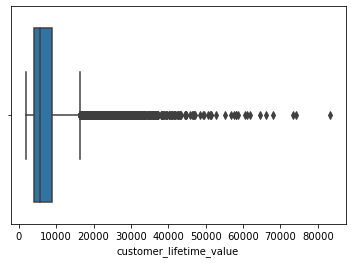

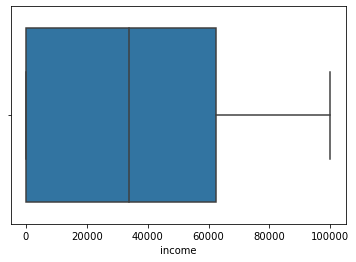

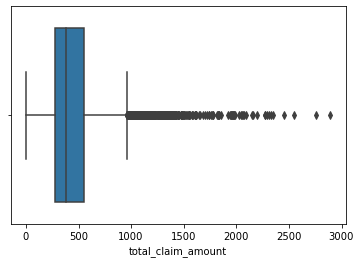

In [307]:
def cont_plot(col):
    
    for col in continuous_df.columns:
        sns.boxplot(x=continuous_df[col])
        plt.show()
    
cont_plot(continuous_df.columns)

In [308]:
# Upper and lower limits for customer_lifetime_value (1,5*iqr)
iqr = np.percentile(continuous_df['customer_lifetime_value'],75) - np.percentile(continuous_df['customer_lifetime_value'],25)
upper_limit = np.percentile(continuous_df['customer_lifetime_value'],75) + 1.5*iqr
lower_limit = np.percentile(continuous_df['customer_lifetime_value'],25) - 1.5*iqr
print('upper_limit for customer_lifetime_value is:', upper_limit)
print('lower_limit for customer_lifetime_value is:', lower_limit)

upper_limit for customer_lifetime_value is: 16414.039911750002
lower_limit for customer_lifetime_value is: -3457.6210762500014


In [309]:
# Upper and lower limits for total_claim_amount (1,5*iqr)
iqr = np.percentile(continuous_df['total_claim_amount'],75) - np.percentile(continuous_df['total_claim_amount'],25)
upper_limit = np.percentile(continuous_df['total_claim_amount'],75) + 1.5*iqr
lower_limit = np.percentile(continuous_df['total_claim_amount'],25) - 1.5*iqr
print('upper_limit for total_claim_amount is:', upper_limit)
print('lower_limit for total_claim_amount is:', lower_limit)

upper_limit for total_claim_amount is: 960.3997301249999
lower_limit for total_claim_amount is: -140.62664687499995


In [310]:
# COMMENT: 
# There seem to be too many outliers for continuous variables in this particular dataset. I will be keeping them. 

### 2. Create a copy of the dataframe for the data wrangling.

In [311]:
data = pd.concat((continuous_df, discrete_df), axis = 1)
data

,customer_lifetime_value,income,total_claim_amount,state,response,coverage,education,effective_to_date,employmentstatus,gender,location_code,marital_status,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
0,2763.52,56274,384.81,Washington,No,0,2,Feb2,1,F,1,Married,69,32,5,0,1,Corporate,A,Offer1,Agent,Two-Door Car,1
1,6979.54,0,1131.46,Arizona,No,1,2,Feb1,0,F,1,Single,94,13,42,0,8,Personal,A,Offer3,Agent,Four-Door Car,1
2,12887.43,48767,566.47,Nevada,No,2,2,Feb2,1,F,1,Married,108,18,38,0,2,Personal,A,Offer1,Agent,Two-Door Car,1
3,7645.86,0,529.88,California,No,0,2,Jan2,0,M,1,Married,106,18,65,0,7,Corporate,A,Offer1,Call Center,SUV,1
4,2813.69,43836,138.13,Washington,No,0,2,Feb1,1,M,0,Single,73,12,44,0,1,Personal,A,Offer1,Agent,Four-Door Car,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,23405.99,71941,198.23,California,No,0,2,Feb1,1,M,2,Married,73,18,89,0,2,Personal,A,Offer2,Web,Four-Door Car,1
9130,3096.51,21604,379.20,California,Yes,1,3,Feb1,1,F,1,Divorced,79,14,28,0,1,Corporate,A,Offer1,Branch,Four-Door Car,1
9131,8163.89,0,790.78,California,No,1,2,Feb1,0,M,1,Single,85,9,37,3,2,Corporate,A,Offer1,Branch,Four-Door Car,1
9132,7524.44,21941,691.20,California,No,1,3,Feb1,1,M,1,Married,96,34,3,0,3,Personal,A,Offer3,Branch,Four-Door Car,2


### 3. Normalizing/scaling variables

#### Xy split

In [312]:
# Before normalizing/scaling, we must do our Xy split. 
# I considered using customer_lifetime_value as the target, but the results in the regression model were quite poor. 
# I finally decided to go for total_claim_amount to see the differences. 

y = data['total_claim_amount']
X = data.drop(['total_claim_amount'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [313]:
display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)

(7307, 22)

(7307,)

(1827, 22)

(1827,)

#### Normalizing numericals

In [314]:
# Train set
X_train_num = X_train.select_dtypes(include = np.number)
transformer = MinMaxScaler().fit(X_train_num)
X_train_num_norm = transformer.transform(X_train_num)
X_train_num_norm = pd.DataFrame(X_train_num_norm, columns=X_train_num.columns)
X_train_num_norm

,customer_lifetime_value,income,coverage,education,employmentstatus,location_code,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,vehicle_size
0,0.21,0.23,0.00,0.50,0.50,1.00,0.04,0.31,0.69,0.00,0.12,0.50
1,0.01,0.21,0.00,0.25,1.00,0.50,0.00,0.94,0.62,0.00,0.00,0.50
2,0.01,0.00,0.00,0.00,0.00,0.50,0.05,0.20,0.78,0.00,0.00,0.00
3,0.13,0.00,0.00,0.00,0.00,0.50,0.24,0.43,0.69,0.00,0.12,0.50
4,0.07,0.26,0.00,0.00,1.00,0.50,0.02,0.31,0.39,0.00,0.12,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
7302,0.33,0.21,1.00,0.50,1.00,0.50,0.57,0.17,0.47,0.00,0.12,0.00
7303,0.04,0.99,0.50,0.25,0.50,0.00,0.27,0.20,0.36,0.20,0.00,0.50
7304,0.16,0.00,0.50,0.25,0.00,0.50,0.33,0.14,0.57,0.00,0.12,0.50
7305,0.08,0.20,0.00,0.00,1.00,0.50,0.24,0.49,0.41,0.20,1.00,0.50


In [315]:
# Test set
X_test_num = X_test.select_dtypes(include = np.number)
X_test_num_norm = transformer.transform(X_test_num)
X_test_num_norm = pd.DataFrame(X_test_num_norm, columns=X_test_num.columns)
X_test_num_norm

,customer_lifetime_value,income,coverage,education,employmentstatus,location_code,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,vehicle_size
0,0.09,0.28,0.00,0.00,0.50,0.50,0.22,0.17,0.27,0.00,0.25,0.50
1,0.01,0.47,0.00,0.25,0.50,0.50,0.02,0.17,0.35,0.00,0.00,0.00
2,0.03,0.37,0.00,0.25,0.50,0.50,0.19,0.37,0.18,0.20,0.00,0.50
3,0.01,0.18,0.00,0.50,1.00,0.50,0.04,0.83,0.71,0.00,0.00,0.50
4,0.03,0.00,0.00,0.50,0.00,0.50,0.03,0.20,0.76,0.00,0.50,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...
1822,0.04,0.31,0.00,0.50,0.50,0.00,0.00,0.23,0.36,0.00,0.62,0.50
1823,0.07,0.55,0.50,0.50,0.50,0.00,0.15,0.14,0.11,0.60,1.00,0.50
1824,0.01,0.72,0.00,0.00,0.50,1.00,0.05,0.69,0.59,0.00,0.00,0.50
1825,0.02,0.68,0.50,0.25,0.50,0.00,0.11,0.69,0.54,0.00,0.00,0.50


#### One Hot Encoding categoricals

In [316]:
# Train set

In [317]:
X_train_cat = X_train.select_dtypes(object)

encoder = OneHotEncoder(drop='first').fit(X_train_cat)
encoded = encoder.transform(X_train_cat).toarray()
cols = encoder.get_feature_names_out(input_features=X_train_cat.columns)
X_train_cat_norm = onehot_encoded = pd.DataFrame(encoded, columns=cols)

In [318]:
# Test set

In [319]:
X_test_cat = X_test.select_dtypes(object)

encoded = encoder.transform(X_test_cat).toarray()
cols = encoder.get_feature_names_out(input_features=X_test_cat.columns)
X_test_cat_norm = onehot_encoded = pd.DataFrame(encoded, columns=cols)

#### Concatenating DataFrames

In [320]:
X_train_scaled = pd.concat((X_train_num_norm, X_train_cat_norm), axis = 1)
X_test_scaled = pd.concat((X_test_num_norm, X_test_cat_norm), axis = 1)
display(X_train_scaled.head(2))
display(X_test_scaled.head(2))

,customer_lifetime_value,income,coverage,education,employmentstatus,location_code,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,vehicle_size,state_California,state_Nevada,state_Oregon,state_Washington,response_Yes,gender_M,marital_status_Married,marital_status_Single,policy_type_Personal,policy_type_Special,renew_offer_type_Offer2,renew_offer_type_Offer3,renew_offer_type_Offer4,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury,vehicle_class_SUV,vehicle_class_Two-Door Car
0,0.21,0.23,0.00,0.50,0.50,1.00,0.04,0.31,0.69,0.00,0.12,0.50,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.01,0.21,0.00,0.25,1.00,0.50,0.00,0.94,0.62,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,customer_lifetime_value,income,coverage,education,employmentstatus,location_code,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,vehicle_size,state_California,state_Nevada,state_Oregon,state_Washington,response_Yes,gender_M,marital_status_Married,marital_status_Single,policy_type_Personal,policy_type_Special,renew_offer_type_Offer2,renew_offer_type_Offer3,renew_offer_type_Offer4,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury,vehicle_class_SUV,vehicle_class_Two-Door Car
0,0.09,0.28,0.00,0.00,0.50,0.50,0.22,0.17,0.27,0.00,0.25,0.50,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
1,0.01,0.47,0.00,0.25,0.50,0.50,0.02,0.17,0.35,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


#### y_train & y_test index reset

In [321]:
# This step is needed because during the transformation process of X_train_scaled the index has been reset.
# We then need to reset the index for y_train & y_test to make them match.

y_train = y_train.reset_index(drop=True) 
y_test = y_test.reset_index(drop=True) 

# Models

In [322]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### LinearRegression

In [323]:
lm = linear_model.LinearRegression()
lm.fit(X_train_scaled,y_train)

LinearRegression()

In [324]:
from sklearn.metrics import r2_score
predictions = lm.predict(X_train_scaled)
print('R2 score for the training set is:', r2_score(y_train, predictions))

R2 score for the training set is: 0.6154763739600597


In [325]:
predictions_test = lm.predict(X_test_scaled)
print('R2 score for the test set is:', r2_score(y_test, predictions_test))

R2 score for the test set is: 0.6417177599083381


### KNeighborsRegressor

In [326]:
KNN = KNeighborsRegressor(n_neighbors=6, algorithm = 'brute')
KNN.fit(X_train_scaled, y_train)

KNeighborsRegressor(algorithm='brute', n_neighbors=6)

In [327]:
score = KNN.score(X_test_scaled, y_test)
score

0.46234041111102697

In [328]:
score_train = KNN.score(X_train_scaled, y_train)
score_train

0.6246016034036457